In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import torch
from torch.nn import Sequential, Linear
from torch.utils.data import TensorDataset, DataLoader
from itertools import cycle
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
)
from bb_opt.src.deep_ensemble import (
    NNEnsemble,
    RandomNN,
    combine_means_variances,
    compute_negative_log_likelihood,
    compute_weighted_nll,
    get_model_deep_ensemble
)
from bb_opt.src.utils import get_path, load_checkpoint, save_checkpoint, jointplot, load_data
from gpu_utils.utils import gpu_init

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

%matplotlib inline

Running on GPU 0


In [2]:
n_train = 1000
n_val = 100
batch_size = 128
n_hidden = 100
non_linearity = 'ReLU'
top_k_percent = 1

data_root = "/cluster/nhunt/github/bb_opt/data"
project = "dna_binding"
dataset = "crx_ref_r1"

data = load_data(data_root, project, dataset, n_train, n_val, standardize_labels=False, device=device)
n_inputs = data.train.inputs.shape[1]

train_loader = DataLoader(
    TensorDataset(data.train.inputs, data.train.labels),
    batch_size=batch_size,
    shuffle=True
)

/cluster/nhunt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
# fname = "../models_nathan/crx_de_900_766.pkl"
# with open(fname, "rb") as f:
#     nonlinearity_names = pickle.load(f)

In [4]:
n_models = 250

mins = data.train.inputs.min(dim=0)[0]
maxes = data.train.inputs.max(dim=0)[0]
adversarial_epsilon = 0.01 * (maxes - mins)
adversarial_epsilon = None

# model_kwargs = {
#     n_inputs, batch_size, n_models, n_hidden, adversarial_epsilon
# }

# model = NN(n_inputs, n_hidden).to(device)
model = get_model_deep_ensemble(n_inputs, batch_size, n_models, n_hidden, adversarial_epsilon, device)#, nonlinearity_names)
# model = NNEnsemble(n_models, RandomNN, model_kwargs(), adversarial_epsilon=adversarial_epsilon).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# load_checkpoint("../models_nathan/de_mves/40.pth", model, optimizer)

## Ensemble Testing

In [5]:
train_nll = []
train_mse = []
test_nll = []
test_mse = []
epoch = 0

In [ ]:
for epoch in range(epoch, epoch + 30_000):
    model.train()
    for batch in train_loader:
        batch_inputs, batch_labels = batch
        optimizer.zero_grad()

        means, variances = model(batch_inputs, batch_labels)

        negative_log_likelihood, mse = compute_negative_log_likelihood(batch_labels, means, variances, return_mse=True)
#         negative_log_likelihood, mse = compute_weighted_nll(batch_labels, means, variances, return_mse=True)
        negative_log_likelihood.backward()

        optimizer.step()

        train_nll.append(negative_log_likelihood.item())
        train_mse.append(mse.item())

    model.eval()
    with torch.no_grad():
        means, variances = model(data.test.inputs)

        negative_log_likelihood, mse = compute_negative_log_likelihood(data.test.labels, means, variances, return_mse=True)
#         negative_log_likelihood, mse = compute_weighted_nll(test_labels, means, variances, return_mse=True)        
        test_nll.append(negative_log_likelihood.item())
        test_mse.append(mse.item())

    if epoch % 100 == 0:
        print(f'[E{epoch}] Train NLL = {train_nll[-1]:,.0f}. Test NLL = {test_nll[-1]:,.0f}')

/cluster/nhunt/github/bb_opt/src/deep_ensemble.py:72: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  hidden = self.non_linearity(self.hidden(x))


[E0] Train NLL = 33,860,094,085,038,080. Test NLL = 31,463,478,711,549,952
[E100] Train NLL = 589,451,914,903,552. Test NLL = 1,351,122,354,700,288
[E200] Train NLL = 746,800,659,038,208. Test NLL = 955,000,138,235,904
[E300] Train NLL = 398,459,819,524,096. Test NLL = 720,842,346,463,232


In [51]:
# fname = f"../models_nathan/crx_de_{len(data.train.inputs)}_{round(len(train_nll) / 1000)}.pth"
# save_checkpoint(fname, model, optimizer)

In [14]:
nonlinearity_names = []
for m in model.models:
    try:
        name = m.non_linearity.__name__
    except AttributeError:
        name = type(m.non_linearity).__name__
    nonlinearity_names.append(name)

In [7]:
with torch.no_grad():
    pred_means, pred_vars = model(data.test.inputs.cpu())

/cluster/nhunt/github/bb_opt/src/deep_ensemble.py:72: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  hidden = self.non_linearity(self.hidden(x))


In [8]:
pred_means = pred_means.numpy()
pred_vars = pred_vars.numpy()

In [9]:
pred_means.shape

(250, 31896)

In [10]:
train_inputs = data.train.inputs.cpu().numpy()
inputs = data.test.inputs.cpu().numpy()
labels = data.test.labels.cpu().numpy()

In [11]:
from bb_opt.src.diagnostic_plots import diagnostic_plots

/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


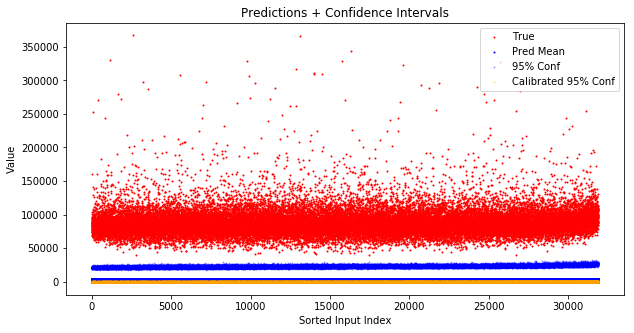

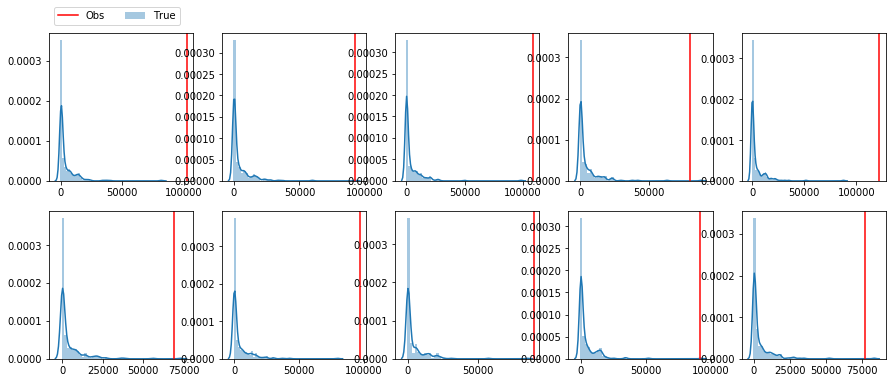

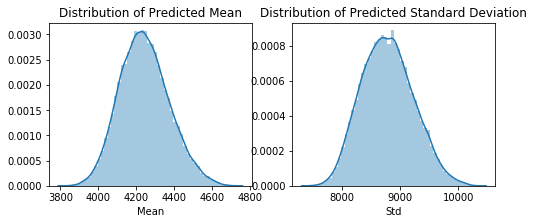

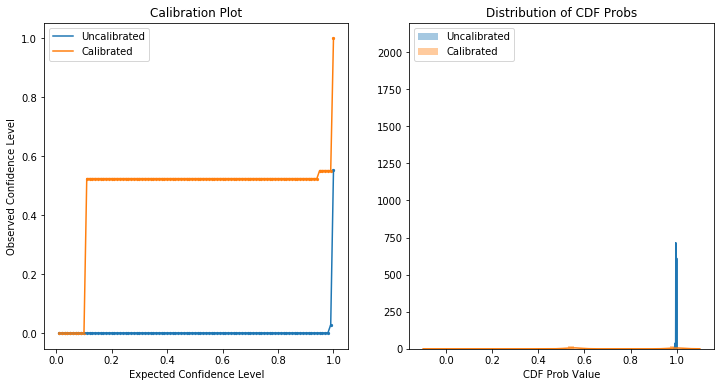

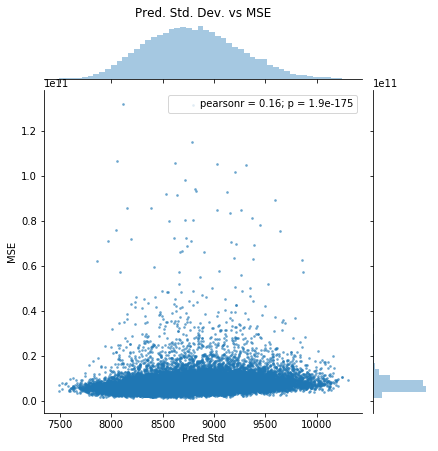

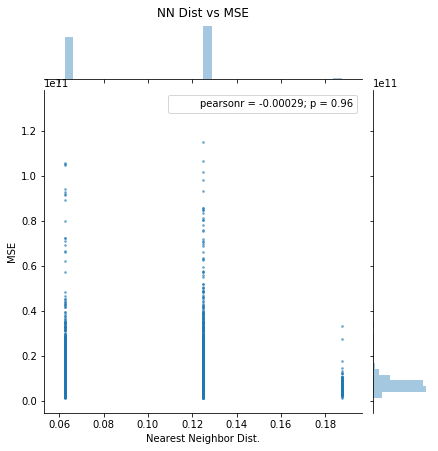

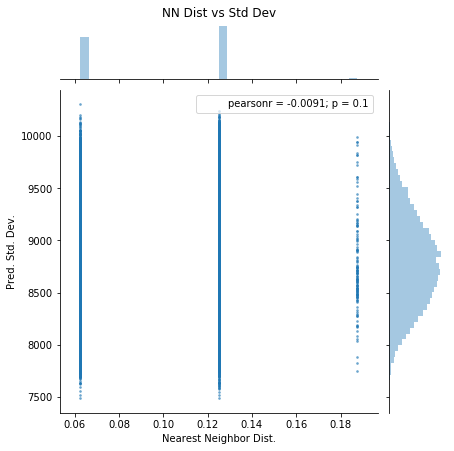

In [12]:
conf_level = 0.95
diagnostic_plots(inputs, train_inputs, pred_means, labels, conf_level)s

In [ ]:
%notify

In [ ]:
# save_checkpoint(f"test_models/mves_m{n_models}_tr{n_train / 1000:g}k.pth", model, optimizer)
# load_checkpoint(f"test_models/mves_m{n_models}_tr{n_train / 1000:g}k.pth", model, optimizer)

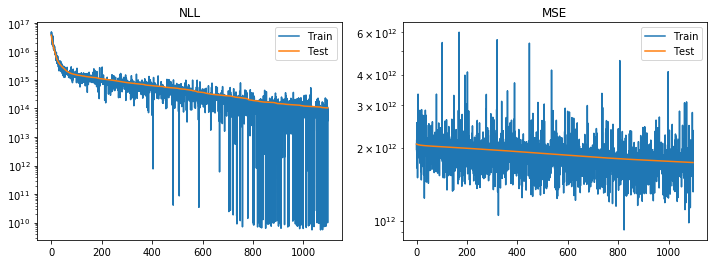

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(np.linspace(0, len(test_nll), len(train_nll)), train_nll, label="Train")
plt.plot(test_nll, label="Test")
plt.yscale("log")
plt.legend()
plt.title("NLL")

plt.subplot(122)
plt.plot(np.linspace(0, len(test_mse), len(train_mse)), train_mse, label="Train")
plt.plot(test_mse, label="Test")
plt.yscale("log")
plt.legend()
plt.title("MSE");

/cluster/nhunt/github/bb_opt/src/deep_ensemble.py:72: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  hidden = self.non_linearity(self.hidden(x))
/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


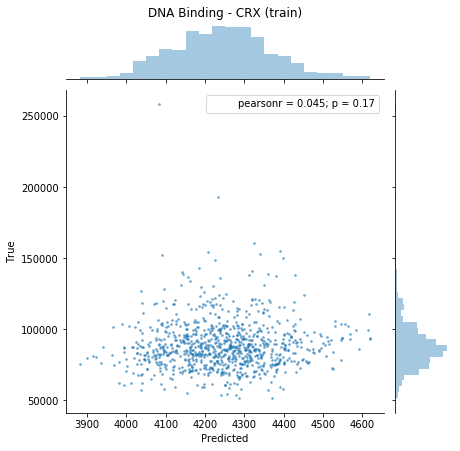

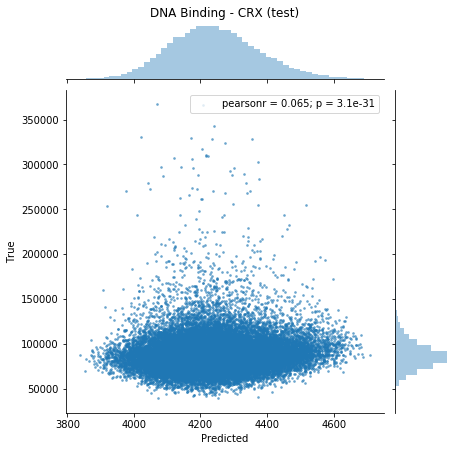

In [17]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

with torch.no_grad():
    means, variances = model(data.train.inputs)
mean, variance = combine_means_variances(means, variances)
jointplot(mean, data.train.labels, title=train_title)

with torch.no_grad():
    means, variances = model(data.test.inputs)
mean, variance = combine_means_variances(means, variances)
jointplot(mean, data.test.labels, title=test_title);

98 72

In [12]:
# save_checkpoint("./de_uniforms.pth", model, optimizer)

In [19]:
with torch.no_grad():
    means, variances = model(test_inputs)
means.shape

/cluster/nhunt/github/bb_opt/src/deep_ensemble.py:72: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  hidden = self.non_linearity(self.hidden(x))


torch.Size([50, 31896])

In [20]:
preds = means
n_max_dist_points = 200

In [21]:
means = preds.mean(0)
max_idx = means.sort(descending=True)[1][:n_max_dist_points]
max_dist = preds[:, max_idx]
max_dist.shape

torch.Size([50, 200])

In [22]:
preds.shape

torch.Size([50, 31896])

In [14]:
max_dist_idx = means.max(dim=1)[1]
fraction_unique = len(set(max_dist_idx.tolist())) / len(max_dist_idx)
max_dist_mean = test_labels[max_dist_idx].mean().item()
max_dist_max = test_labels[max_dist_idx].max().item()

print(f"Mean: {max_dist_mean:,.0f}")
print(f"Max: {max_dist_max:,.0f}")
print("Fraction unique inputs in max_dist:", fraction_unique)

Mean: 89,329
Max: 122,493
Fraction unique inputs in max_dist: 1.0


| steps | Fraction unique | mean | max | Notes |
|---|---|---|---|---|
| 6000 | 0.52 | 122K | 263K | $M = 50$, random activations (converged?) |
| 6000 | 0.56 | 120K | 270K | $M = 50$, default init (not converged) |

Mm, not sure how much more uncertainty we actually have at convergence; I think some of the models, probably with bad inits, take a long time to converge, so we get diversity along the way because they're still doing a poor job (e.g. they think the max train value is ~4K when it's 258K while other models at least think it's 130K)

In [1]:
max_dist = means.max(dim=1)[0]
max_dist = max_dist.unsqueeze(1)
max_dist.shape

NameError: name 'means' is not defined

In [51]:
from bb_opt.src.hsic import dimwise_mixrq_kernels, sqdist, total_hsic, mixrq_kernels

kernel = mixrq_kernels

In [ ]:
preds = means
batch_dists = preds[:, :3]

In [66]:
max_dist_kernel = kernel(sqdist(max_dist))
batch_sqdists = sqdist(batch_dists)
point_sqdists = sqdist(preds)

all_mi = []

for point_idx in range(preds.shape[1]):
    point_kernel = kernel(torch.cat((batch_sqdists, point_sqdists[:, :, point_idx:point_idx + 1]), dim=-1))
    point_kernel = point_kernel.mean(dim=-1).unsqueeze(-1)
    all_mi.append(total_hsic(torch.cat((max_dist_kernel, point_kernel), dim=-1)))

In [68]:
q = max_dist.new_empty(3)
q

tensor([50.0000,  0.5000,  1.0000], device='cuda:0')

In [75]:
b = torch.randint(0, 5, (3, 2))
b

tensor([[0., 3.],
        [4., 4.],
        [1., 0.]])

In [77]:
b.transpose(1, 0)

tensor([[0., 4., 1.],
        [3., 4., 0.]])

In [69]:
q[0] = 2
q

tensor([2.0000, 0.5000, 1.0000], device='cuda:0')

In [71]:
np.array(all_mi).max(), np.array(all_mi).min()

(0.020403506, 0.019613404)

In [63]:
np.array(all_mi)

array([-77246.945, -68639.4  , -65547.03 , ..., -62093.87 , -68529.86 ,
       -63720.97 ], dtype=float32)

In [44]:
k = torch.cat((batch_sqdists.unsqueeze(2).unsqueeze(-1).expand(-1, -1, -1, -1, 100),
               point_sqdists.unsqueeze(2).unsqueeze(3)), dim=3)
k.shape

torch.Size([50, 50, 1, 4, 100])

In [45]:
k = k.mean(dim=3)
k.shape

torch.Size([50, 50, 1, 100])

In [47]:
k = mixrq_kernels(k)

RuntimeError: The size of tensor a (50) must match the size of tensor b (5) at non-singleton dimension 0

In [ ]:
max_dist

In [ ]:
kk = torch.cat(())

In [24]:
all_mi = []
for point_idx in range(preds.shape[1]):
    batch = torch.cat((batch_dists, preds[:, point_idx:point_idx + 1]), dim=1)
    print(batch.shape)
    batch_kernel = kernel(batch.unsqueeze(1))
    print(batch_kernel.shape)
    break

torch.Size([50, 4])
torch.Size([50, 50, 1])


In [20]:
preds[:, 5:6].shape

torch.Size([50, 1])

In [19]:
((batch_dists - preds[:, 5:6]) ** 2).shape

torch.Size([50, 3])

In [35]:
m = means.unsqueeze(1)
m.shape

torch.Size([50, 1, 31896])

In [ ]:
total_hsic_batched(max_dist, means[:, :, 0:1], dimwise_mixrq_kernels)

[autoreload of IPython.core.ultratb failed: Traceback (most recent call last):
  File "/cluster/nhunt/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    if py_filename in self.failed:
  File "/cluster/nhunt/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    except:
  File "/cluster/nhunt/anaconda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/cluster/nhunt/anaconda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/cluster/nhunt/anaconda/lib/python3.6/site-packages/IPython/core/ultratb.py", line 126, in <module>
    import IPython.utils.colorable as colorable
AttributeError: module 'IPython' has

In [38]:
total_hsic_batched(max_dist, m[:, :, 0:1], dimwise_mixrq_kernels)

tensor([0.0194], device='cuda:0')

In [24]:
from scipy.stats import kendalltau

In [26]:
sort_idx = test_labels.sort(descending=True)[1]

best_inputs = test_inputs[sort_idx][:1000]
best_labels = test_labels[sort_idx][:1000]


tensor([366908.3750, 366577.5938, 343089.6562,  ...,  40359.6016,
         39924.1211,  39488.6406], device='cuda:0')

* Can you do something with the calibration? Does calibrating change the _order_? If so, maybe select the max based on the highest predicted (calibrated) quantile instead of predicted mean/mode? 

In [9]:
save_fname = "../models_nathan/de_testing/??.pth"
save_checkpoint(save_fname, model, optimizer)

$M = 1$ (no AT, 50% train)

89 87
91 88
92 89
93 90 (2600 @ 128)

$M = 5$ (AT, 1K train)
46 42 (1600 @ 128)
67 62 (2600)
69 62 (3600)
82 68 (4600)
92 71 (6600)
99 71 (12600)

$M = 1$ (AT, 1K train, standardized)
96 68 (10K @ 128)
(NLL is weird for this one; goes up for test but down for train... something wrong with standardization??)



$M = 5$ (no AT, 1K train)
91 71 (6000 @ 128)

$M = 100$ (no AT, 1K train)
91 70 (6000 @ 128)
99 70 (10K)

In [193]:
train_labels.max()

tensor(258252.7969, device='cuda:0')

# AF Testing

In [16]:
n_models = 100
model = get_model_deep_ensemble(n_inputs, batch_size, n_models, n_hidden, adversarial_epsilon, device)
load_checkpoint(f"../models_nathan/de_testing/de_m{n_models}_tr1k.pth", model)

In [17]:
with torch.no_grad():
    means, variances = model(test_inputs)

In [134]:
fraction_unique = len(set(means.max(dim=1)[1].tolist())) / len(means)
print("Fraction unique inputs in max_dist:", fraction_unique)

n_max_dist_points = 5
max_dist = test_inputs[preds.sort(dim=1, descending=True)[1][:, :n_max_dist_points]]
max_dist.shape

Fraction unique inputs in max_dist: 0.05


torch.Size([100, 5, 32])

In [135]:
from bb_opt.src.hsic import total_hsic_batched, dimwise_mixrq_kernels

In [136]:
q = torch.rand((100, 1, 32), device=max_dist.device)
hsic_independent = total_hsic_batched(max_dist, q, dimwise_mixrq_kernels).item()
print(f"HSIC independent RVs:\t{hsic_independent:.5f}")

if max_dist.shape[1] == 1:
    hsic_identical = total_hsic_batched(max_dist, max_dist, dimwise_mixrq_kernels).item()
    print(f"HSIC identical RVs:\t{hsic_identical:.5f}")

HSIC independent RVs:	0.01011


Min: 0.00972
Max: 0.00995


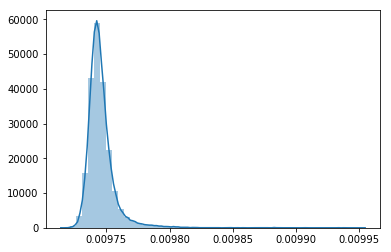

In [137]:
hsics = total_hsic_batched(max_dist, means, dimwise_mixrq_kernels)
print(f"Min: {hsics.min():.5f}")
print(f"Max: {hsics.max():.5f}")
sns.distplot(hsics)

In [138]:
b = None
b = b or {}
b

{}

In [139]:
s = set([1,2,3,4,3,3])
s

{1, 2, 3, 4}

In [140]:
s1 = s.copy()

In [141]:
s.add(98)
s, s1

({1, 2, 3, 4, 98}, {1, 2, 3, 4})

In [144]:
with torch.no_grad():
    means, variances = model(test_inputs, individual_predictions=False)

In [149]:
s = set([243, 21659])

In [148]:
means.sort(descending=True)[1][:10]

tensor([  243, 21659,  1681, 29457, 22245, 23647,  1661,  4526,  7175, 31272],
       device='cuda:0')

In [121]:
hsics

tensor([0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100], device='cuda:0')

In [109]:
mean, variance = combine_means_variances(means, variances)

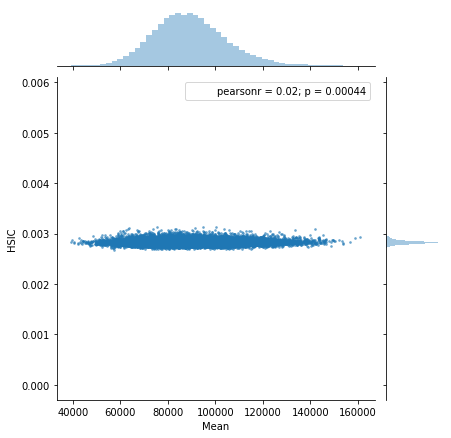

In [110]:
jointplot(mean, hsics, ("Mean", "HSIC"))

In [65]:
means[:, 0:1].shape

torch.Size([100, 1])

In [66]:
max_dist.shape

torch.Size([100, 1, 32])

In [81]:
hsics = total_hsic_batched([max_dist, means[:, 0:1]], means[:, 1:], dimwise_mixrq_kernels)

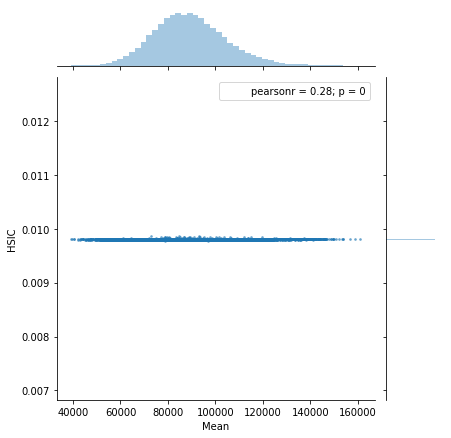

In [83]:
jointplot(mean[1:], hsics, ("Mean", "HSIC"))

In [69]:
from bb_opt.src.hsic import precompute_batch_hsic_stats

In [84]:
preds = means
preds.shape

torch.Size([100, 31896])

In [97]:
n_max_dist_points = 2
test_inputs[preds.sort(dim=1, descending=True)[1][:, :n_max_dist_points]].shape

torch.Size([100, 2, 32])

In [92]:
max_dist.shape

torch.Size([100, 1, 32])

100 7


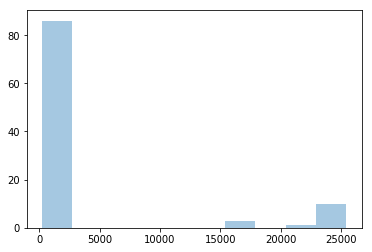

In [220]:
max_value_dist, max_dist = means.max(dim=1)
print(len(max_dist), len(set(max_dist.tolist())))
sns.distplot(max_dist, kde=False)

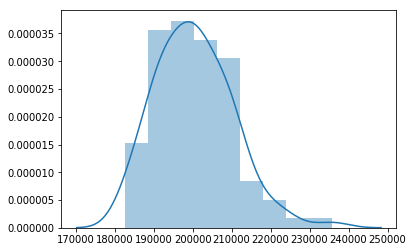

In [221]:
sns.distplot(max_value_dist)

In [225]:
max_value_dist.max().item(), train_labels.max().item()

(235837.921875, 258252.796875)

7 100


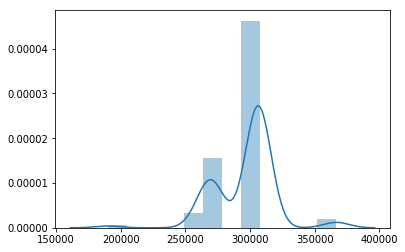

In [200]:
max_dist = [test_labels[sorted_idx[i][:10]].max().item() for i in range(len(sorted_idx))]
print(len(set(max_dist)), len(max_dist))
sns.distplot(max_dist)

In [206]:
np.argmax(max_dist)

14

In [204]:
max(max_dist), test_labels.max().item()

(366908.375, 366908.375)

In [86]:
len(set(q.contiguous().view(-1).tolist()))

21

In [88]:
test_labels.sort(descending=True)[0][:10]

tensor([366908.3750, 366577.5938, 343089.6562, 330452.0000, 328993.2812,
        328504.0938, 327849.2812, 323384.2188, 317339.3750, 311019.8750],
       device='cuda:0')

In [90]:
mean, variance = combine_means_variances(means, variances)

In [171]:
n_samples = 5000
i = 0

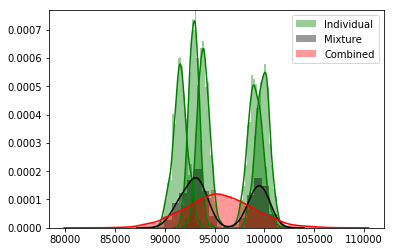

In [175]:
mixture_samples = np.random.normal(means[:, i], variances[:, i].sqrt(),
                                   ((n_samples // model.n_models, model.n_models)))
combined_samples = np.random.normal(mean[i], variance[i].sqrt(), size=n_samples)

for j in range(model.n_models):
    sns.distplot(mixture_samples[:, j], label="Individual" if j == 0 else None, color="green")

sns.distplot(mixture_samples.ravel(), label="Mixture", color="black")
sns.distplot(combined_samples, label="Combined", color="red")
plt.legend()

i += 1

tensor(366908.3750, device='cuda:0')

In [54]:
test_labels[means.argmax(dim=1)]

tensor([141012.4531, 138143.2188, 141012.4531, 141012.4531, 141012.4531],
       device='cuda:0')

In [51]:
means.shape

torch.Size([5, 31896])

# Calibration

In [387]:
with torch.no_grad():
    means, variances = model(train_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((train_labels - mean) / (variance.sqrt() * sqrt2)))

In [388]:
eq = np.array([(cdf_probs <= cdf_prob).float().mean() for cdf_prob in cdf_probs])
eq

array([0.70409775, 0.81341195, 0.7310919 , ..., 0.7262889 , 0.5938716 ,
       0.12171692], dtype=float32)

In [389]:
from sklearn.isotonic import IsotonicRegression

In [390]:
calibration_regressor = IsotonicRegression(0, 1)

In [391]:
calibration_regressor.fit(cdf_probs, eq)

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=1, y_min=0)

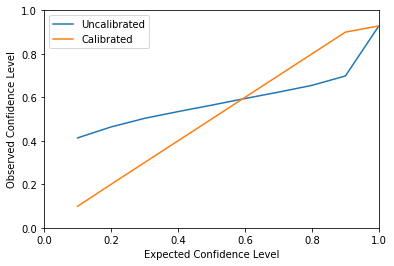

In [392]:
with torch.no_grad():
    means, variances = model(train_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((train_labels - mean) / (variance.sqrt() * sqrt2)))

threshes = np.linspace(.1, 1, 10)
e = [(cdf_probs < thresh).float().mean().item() for thresh in threshes]
plt.plot(threshes, e, label="Uncalibrated")

cdf_probs = calibration_regressor.transform(cdf_probs)
e = [(cdf_probs < thresh).mean() for thresh in threshes]
plt.plot(threshes, e, label="Calibrated")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Expected Confidence Level")
plt.ylabel("Observed Confidence Level")
plt.legend();

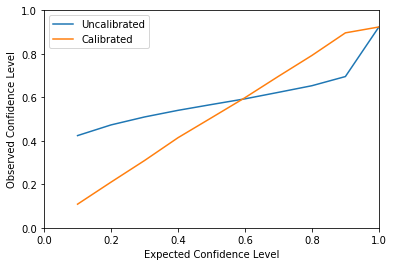

In [393]:
with torch.no_grad():
    means, variances = model(test_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((test_labels - mean) / (variance.sqrt() * sqrt2)))

threshes = np.linspace(.1, 1, 10)
e = [(cdf_probs < thresh).float().mean().item() for thresh in threshes]
plt.plot(threshes, e, label="Uncalibrated")

cdf_probs = calibration_regressor.transform(cdf_probs)
e = [(cdf_probs < thresh).mean() for thresh in threshes]
plt.plot(threshes, e, label="Calibrated")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Expected Confidence Level")
plt.ylabel("Observed Confidence Level")
plt.legend();

# Mean vs Mode

In [15]:
from scipy import stats

def estimate_mode(means, variances, n_points: int=1000) -> float:
    normal = stats.norm(means, variances.sqrt())
    x = np.linspace(means.min(), means.max(), n_points).reshape(-1, 1)
    mode = x[normal.pdf(x).sum(axis=1).argmax(), 0]
    return mode

title = " ".join((project, dataset, "(test)"))

## Small $M$

In [9]:
n_models = 3
model = get_model_deep_ensemble(n_inputs, batch_size, n_models, n_hidden, adversarial_epsilon, device)
save_fname = f"../models_nathan/de_testing/de_m{n_models}_tr1k.pth"
load_checkpoint(save_fname, model)

In [10]:
with torch.no_grad():
    means, variances = model(test_inputs)
mean, variance = combine_means_variances(means, variances)
modes = np.array([estimate_mode(means[:, i], variances[:, i]) for i in range(means.shape[1])])
abs((mean.cpu().numpy() - modes)).mean()

1709.1126877124264

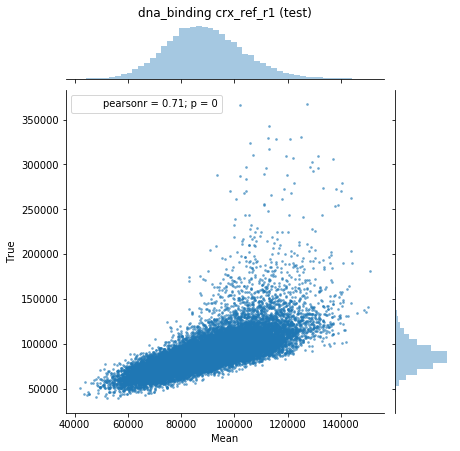

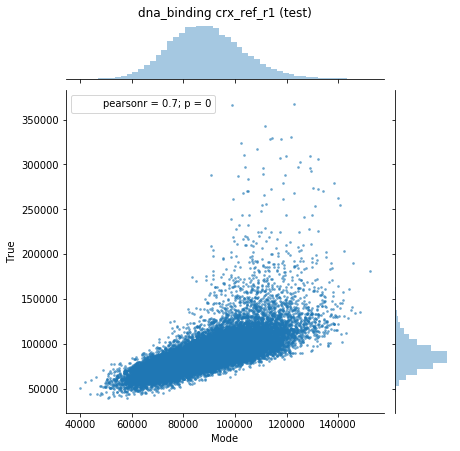

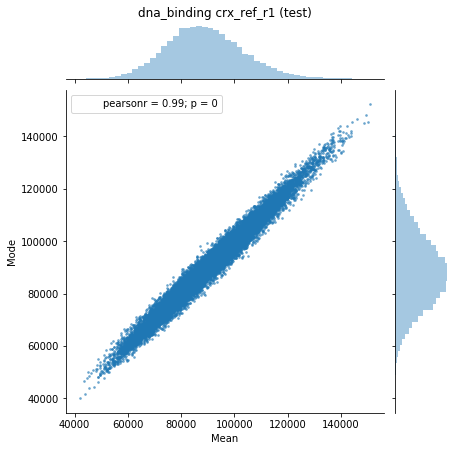

In [17]:
jointplot(mean, test_labels, ("Mean", "True"), title)
jointplot(modes, test_labels, ("Mode", "True"), title)
jointplot(mean, modes, ("Mean", "Mode"), title)

In [18]:
i = 0
n_samples = 2000

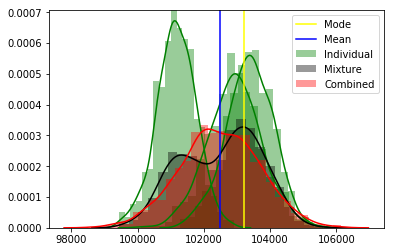

In [19]:
mode = modes[i]
mixture_samples = np.random.normal(means[:, i], variances[:, i].sqrt(),
                                   ((n_samples // model.n_models, model.n_models)))
combined_samples = np.random.normal(mean[i], variance[i].sqrt(), size=n_samples)

for j in range(model.n_models):
    sns.distplot(mixture_samples[:, j], label="Individual" if j == 0 else None, color="green")

sns.distplot(mixture_samples.ravel(), label="Mixture", color="black")
sns.distplot(combined_samples, label="Combined", color="red")
plt.axvline(mode, color="yellow", label="Mode")
plt.axvline(means[:, i].mean(), color="blue", label="Mean")
plt.legend()

i += 1

## Large $M$

In [20]:
n_models = 100
model = get_model_deep_ensemble(n_inputs, batch_size, n_models, n_hidden, adversarial_epsilon, device)
save_fname = f"../models_nathan/de_testing/de_m{n_models}_tr1k.pth"
load_checkpoint(save_fname, model)

In [21]:
with torch.no_grad():
    means, variances = model(test_inputs)
mean, variance = combine_means_variances(means, variances)
modes = np.array([estimate_mode(means[:, i], variances[:, i]) for i in range(means.shape[1])])
abs((mean.cpu().numpy() - modes)).mean()

839.4486784462488

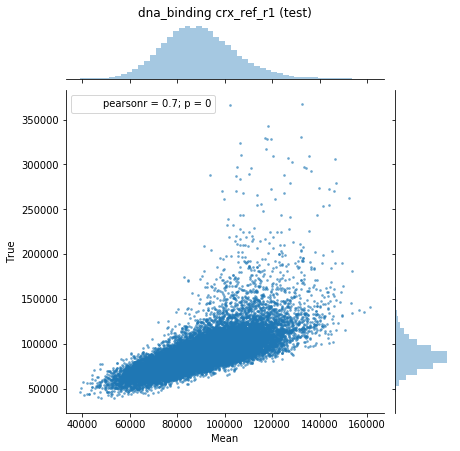

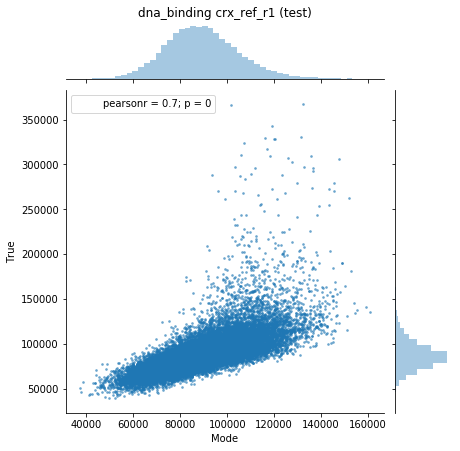

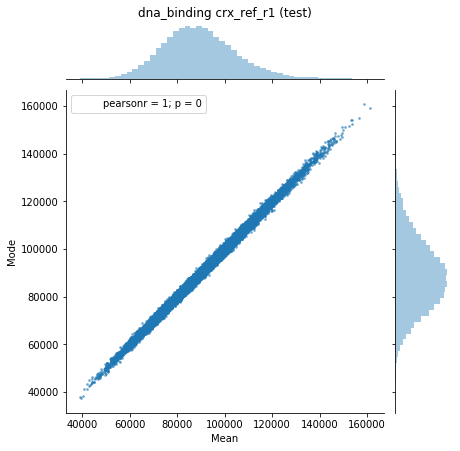

In [22]:
jointplot(mean, test_labels, ("Mean", "True"), title)
jointplot(modes, test_labels, ("Mode", "True"), title)
jointplot(mean, modes, ("Mean", "Mode"), title)

In [23]:
i = 0
n_samples = 2000

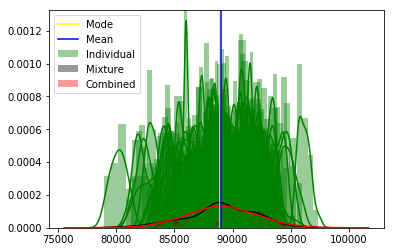

In [44]:
mode = modes[i]
mixture_samples = np.random.normal(means[:, i], variances[:, i].sqrt(),
                                   ((n_samples // model.n_models, model.n_models)))
combined_samples = np.random.normal(mean[i], variance[i].sqrt(), size=n_samples)

for j in range(model.n_models):
    sns.distplot(mixture_samples[:, j], label="Individual" if j == 0 else None, color="green")

sns.distplot(mixture_samples.ravel(), label="Mixture", color="black")
sns.distplot(combined_samples, label="Combined", color="red")
plt.axvline(mode, color="yellow", label="Mode")
plt.axvline(means[:, i].mean(), color="blue", label="Mean")
plt.legend()

i += 1

In [25]:
%notify

# Activation Functions

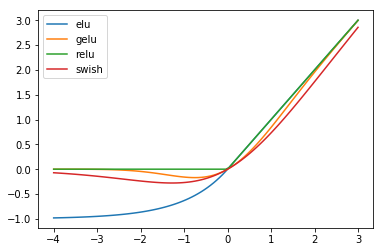

In [20]:
import pandas as pd

sigmoid = lambda x: 1 / (1 + np.exp(-x))

alpha_elu = 1
alpha_selu = 1.67326
lambda_selu = 1.0507

x = np.linspace(-4, 3, 100)
y = {
    "gelu": 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x **3))),
    "relu": np.maximum(0, x),
    "elu": np.where(x < 0, alpha_elu * (np.exp(x) - 1), x),
#     "selu": lambda_selu * np.where(x < 0, alpha_selu * (np.exp(x) - 1), x),
    "swish": x * sigmoid(x)
}

df = pd.DataFrame(y)
df.plot(x=x)